In [708]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
The code for this notebook is hidden for easier reading.
To toggle it on/off, please click <a href="javascript:code_toggle()">here</a>.''')

In [709]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
import seaborn as sns
from sklearn import linear_model
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Data Cleaning

**Data: Crime In New York - [2013](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv).**

In [710]:
path = 'https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv'
crime = pd.read_csv(path)

In [711]:
pd.options.mode.chained_assignment = None

crime.columns = ['city','population','violent_crime','murder','rape_revised','rape_legacy','robbery','aggravated_assault','property_crime','burglary','larceny_theft','vehicle_theft','arson']
crime.drop(labels=[0,1,2,3,352,353,354],axis=0,inplace=True)
crime.drop(labels=['city','rape_revised'],axis=1,inplace=True)

columns = list(crime.columns)
for column in columns:
     crime[column]=crime[column].str.replace(',','')

crime = crime.apply(pd.to_numeric)
crime = crime.dropna()

In [712]:
crime.head()

,population,violent_crime,murder,rape_legacy,robbery,aggravated_assault,property_crime,burglary,larceny_theft,vehicle_theft,arson
4,1861,0,0,0,0,0,12,2,10,0,0.0
5,2577,3,0,0,0,3,24,3,20,1,0.0
6,2846,3,0,0,0,3,16,1,15,0,0.0
10,1781,3,0,0,0,3,10,0,10,0,0.0
11,118296,107,1,7,31,68,2118,204,1882,32,3.0


In [713]:
crime.describe()

,population,violent_crime,murder,rape_legacy,robbery,aggravated_assault,property_crime,burglary,larceny_theft,vehicle_theft,arson
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,14787.053476,45.978610,0.566845,2.192513,16.556150,26.663102,339.823529,65.037433,260.871658,13.914439,1.871658
std,27220.701187,201.362989,3.552914,9.124901,81.476501,109.234772,965.182269,242.693164,675.898585,57.360520,10.693411
min,526.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2195.000000,1.000000,0.000000,0.000000,0.000000,0.000000,19.500000,3.000000,16.000000,0.000000,0.000000
50%,6487.000000,4.000000,0.000000,0.000000,1.000000,3.000000,73.000000,11.000000,62.000000,2.000000,0.000000
75%,16109.000000,17.000000,0.000000,1.000000,4.000000,11.000000,297.000000,39.000000,240.500000,5.000000,1.000000
max,210562.000000,2107.000000,42.000000,92.000000,918.000000,1055.000000,10051.000000,2587.000000,6855.000000,609.000000,132.000000


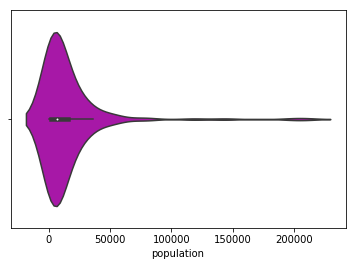

In [714]:
population = sns.violinplot(crime['population'], color='m')

In [715]:
q25 = crime['population'].quantile(0.25)
q75 = crime['population'].quantile(0.75)
iqr = q75 - q25
maximum = q75 + (iqr * 1.5)
crime=crime.where(crime['population'] < maximum)

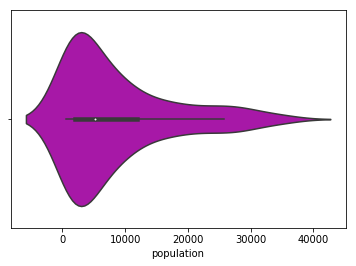

In [716]:
population = sns.violinplot(crime['population'], color='m')

# Linear Regression Model 

## Train-Test Split

In [717]:
crime = crime.replace([np.inf, -np.inf], np.nan).dropna(how="all")

In [718]:
Y = crime['property_crime']
X = crime[['aggravated_assault','arson','burglary','larceny_theft','murder','population','rape_legacy','robbery','vehicle_theft','violent_crime']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=0)

## Fitting to Training Data

In [719]:
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-Squared:')
print(regr.score(X_train, Y_train))


Coefficients: 
 [-1.13603497e-14 -1.51545443e-14  1.00000000e+00  1.00000000e+00
  5.50168541e-14  2.77555756e-17 -2.64678348e-14 -1.22860435e-14
  1.00000000e+00  5.75171963e-15]

Intercept: 
 1.7053025658242404e-13

R-Squared:
1.0


In [720]:
crime_train = pd.concat([X_train, Y_train], axis=1)
lf = 'property_crime ~ aggravated_assault + arson + burglary + larceny_theft + murder + population + rape_legacy + robbery + vehicle_theft + violent_crime'
lm = smf.ols(formula=lf, data=crime_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.075e+28
Date:                Sun, 11 Mar 2018   Prob (F-statistic):               0.00
Time:                        18:57:21   Log-Likelihood:                 2112.8
No. Observations:                  86   AIC:                            -4206.
Df Residuals:                      76   BIC:                            -4181.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -7.422e-14   8.89

### Dropped 'robbery': p = 0.959

In [721]:
Y = crime['property_crime']
X = crime[['aggravated_assault','arson','burglary','larceny_theft','murder','population','rape_legacy','vehicle_theft','violent_crime']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=0)

In [722]:
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-Squared:')
print(regr.score(X_train, Y_train))


Coefficients: 
 [ 1.52276606e-15 -3.82957555e-14  1.00000000e+00  1.00000000e+00
  4.75403597e-14  7.63278329e-17 -1.44226943e-14  1.00000000e+00
 -6.98326488e-15]

Intercept: 
 -1.9895196601282805e-13

R-Squared:
1.0


In [723]:
crime_train = pd.concat([X_train, Y_train], axis=1)
lf = 'property_crime ~ aggravated_assault + arson + burglary + larceny_theft + murder + population + rape_legacy + vehicle_theft + violent_crime'
lm = smf.ols(formula=lf, data=crime_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.327e+28
Date:                Sun, 11 Mar 2018   Prob (F-statistic):               0.00
Time:                        18:57:21   Log-Likelihood:                 2121.8
No. Observations:                  86   AIC:                            -4224.
Df Residuals:                      76   BIC:                            -4199.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -3.547e-14      8

### Dropped 'murder': p = 0.960

In [724]:
Y = crime['property_crime']
X = crime[['aggravated_assault','arson','burglary','larceny_theft','population','rape_legacy','vehicle_theft','violent_crime']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=0)

In [725]:
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-Squared:')
print(regr.score(X_train, Y_train))


Coefficients: 
 [ 8.90232463e-15 -4.76008122e-14  1.00000000e+00  1.00000000e+00
 -2.08166817e-17 -1.01851036e-14  1.00000000e+00 -5.91936439e-15]

Intercept: 
 8.526512829121202e-14

R-Squared:
1.0


In [726]:
crime_train = pd.concat([X_train, Y_train], axis=1)
lf = 'property_crime ~ aggravated_assault + arson + burglary + larceny_theft + population + rape_legacy + vehicle_theft + violent_crime'
lm = smf.ols(formula=lf, data=crime_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.544e+28
Date:                Sun, 11 Mar 2018   Prob (F-statistic):               0.00
Time:                        18:57:21   Log-Likelihood:                 2122.7
No. Observations:                  86   AIC:                            -4227.
Df Residuals:                      77   BIC:                            -4205.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -2.054e-15   7.84

### Dropped 'aggravated_assault': p = 0.993

In [727]:
Y = crime['property_crime']
X = crime[['arson','burglary','larceny_theft','population','rape_legacy','vehicle_theft','violent_crime']]

In [728]:
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-Squared:')
print(regr.score(X_train, Y_train))


Coefficients: 
 [ 8.90232463e-15 -4.76008122e-14  1.00000000e+00  1.00000000e+00
 -2.08166817e-17 -1.01851036e-14  1.00000000e+00 -5.91936439e-15]

Intercept: 
 8.526512829121202e-14

R-Squared:
1.0


In [729]:
crime_train = pd.concat([X_train, Y_train], axis=1)
lf = 'property_crime ~ arson + burglary + larceny_theft + population + rape_legacy + vehicle_theft + violent_crime'
lm = smf.ols(formula=lf, data=crime_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.720e+28
Date:                Sun, 11 Mar 2018   Prob (F-statistic):               0.00
Time:                        18:57:21   Log-Likelihood:                 2121.1
No. Observations:                  86   AIC:                            -4226.
Df Residuals:                      78   BIC:                            -4207.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.734e-13    7.5e-13      0.231

### Dropped 'rape_legacy': p = 0.986

In [730]:
Y = crime['property_crime']
X = crime[['arson','burglary','larceny_theft','population','vehicle_theft','violent_crime']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=0)

In [731]:
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-Squared:')
print(regr.score(X_train, Y_train))


Coefficients: 
 [-9.82442697e-13  1.00000000e+00  1.00000000e+00  0.00000000e+00
  1.00000000e+00 -2.97635180e-15]

Intercept: 
 5.400124791776761e-13

R-Squared:
1.0


In [732]:
crime_train = pd.concat([X_train, Y_train], axis=1)
lf = 'property_crime ~ arson + burglary + larceny_theft + population + vehicle_theft + violent_crime'
lm = smf.ols(formula=lf, data=crime_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.925e+28
Date:                Sun, 11 Mar 2018   Prob (F-statistic):               0.00
Time:                        18:57:21   Log-Likelihood:                 2118.7
No. Observations:                  86   AIC:                            -4223.
Df Residuals:                      79   BIC:                            -4206.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.017e-13   7.66e-13      0.133

### Dropped 'violent_crime': p = 0.976

In [733]:
Y = crime['property_crime']
X = crime[['arson','burglary','larceny_theft','population','vehicle_theft']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=0)

In [734]:
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-Squared:')
print(regr.score(X_train, Y_train))


Coefficients: 
 [1.70057194e-13 1.00000000e+00 1.00000000e+00 0.00000000e+00
 1.00000000e+00]

Intercept: 
 -1.3642420526593924e-12

R-Squared:
1.0


In [735]:
crime_train = pd.concat([X_train, Y_train], axis=1)
lf = 'property_crime ~ arson + burglary + larceny_theft + population + vehicle_theft'
lm = smf.ols(formula=lf, data=crime_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.860e+28
Date:                Sun, 11 Mar 2018   Prob (F-statistic):               0.00
Time:                        18:57:21   Log-Likelihood:                 2127.4
No. Observations:                  86   AIC:                            -4243.
Df Residuals:                      80   BIC:                            -4228.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.138e-14   6.88e-13      0.017

### Dropped 'arson': p = 0.863

In [736]:
Y = crime['property_crime']
X = crime[['burglary','larceny_theft','population','vehicle_theft']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=0)

In [737]:
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-Squared:')
print(regr.score(X_train, Y_train))


Coefficients: 
 [1. 1. 0. 1.]

Intercept: 
 1.3358203432289883e-12

R-Squared:
1.0


In [738]:
crime_train = pd.concat([X_train, Y_train], axis=1)
lf = 'property_crime ~ burglary + larceny_theft + population + vehicle_theft'
lm = smf.ols(formula=lf, data=crime_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.940e+29
Date:                Sun, 11 Mar 2018   Prob (F-statistic):               0.00
Time:                        18:57:21   Log-Likelihood:                 2199.6
No. Observations:                  86   AIC:                            -4389.
Df Residuals:                      81   BIC:                            -4377.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.276e-12   2.95e-13      4.332

## Checking Assumptions

### Linear Relationship

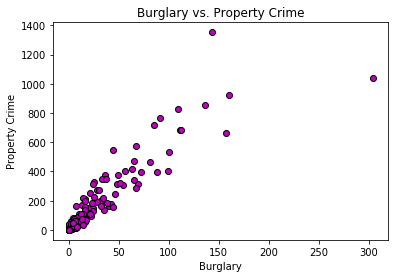

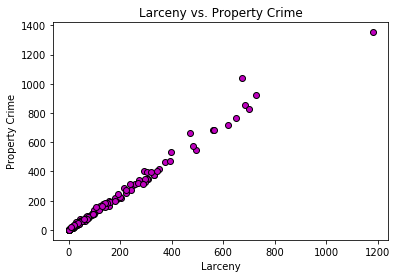

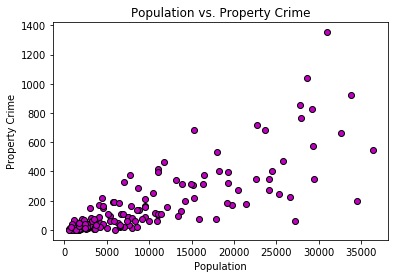

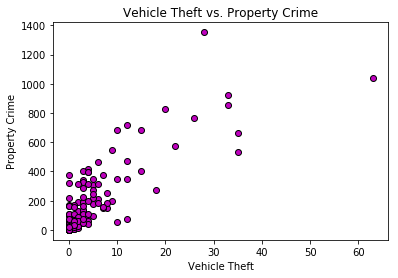

In [739]:
plt.scatter(y=crime['property_crime'], x=crime['burglary'], c='m',edgecolors='k')
plt.ylabel('Property Crime')
plt.xlabel('Burglary')
plt.title('Burglary vs. Property Crime')
plt.show()

plt.scatter(y=crime['property_crime'], x=crime['larceny_theft'],c='m',edgecolors='k')
plt.ylabel('Property Crime')
plt.xlabel('Larceny')
plt.title('Larceny vs. Property Crime')
plt.show()

plt.scatter(y=crime['property_crime'], x=crime['population'],c='m',edgecolors='k')
plt.ylabel('Property Crime')
plt.xlabel('Population')
plt.title('Population vs. Property Crime')
plt.show()

plt.scatter(y=crime['property_crime'], x=crime['vehicle_theft'],c='m',edgecolors='k')
plt.ylabel('Property Crime')
plt.xlabel('Vehicle Theft')
plt.title('Vehicle Theft vs. Property Crime')
plt.show()

**Features are linearly related to the target.** 

### Multivariate Normality

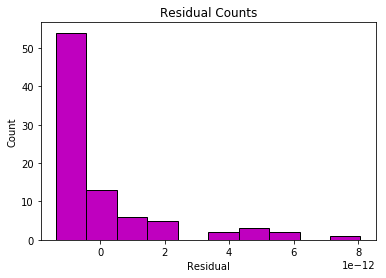

In [740]:
predicted = regr.predict(X_train).ravel()
actual = Y_train
residual = actual - predicted

plt.hist(residual,color='m',edgecolor='k')
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

**The residuals aren't normally distributed.**

### Homoscedasticity

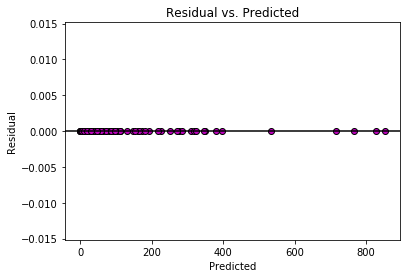

In [741]:
plt.scatter(predicted, residual,c='m',edgecolors='k')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0,c='k')
plt.title('Residual vs. Predicted')
plt.show()

**Error term variance is similar across features.**

### Low Multicollinearity

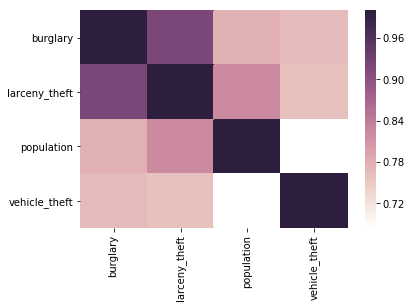

In [742]:
correlation_matrix = X_train.corr()
multicollinearity = sns.heatmap(correlation_matrix, cmap=sns.cubehelix_palette(light=1, as_cmap=True))
ticks = plt.xticks(rotation=90) 

**Some of the features are very highly correlated with each other:**
- 'burglary' & 'larceny_theft'
- 'burglary' & 'population'
- 'burglary' & 'vehicle_theft'
- 'larceny_theft' & 'vehicle_theft'
- 'population' & 'larceny_theft'


## Finalizing the Model

### Combining 'burglary', 'larceny_theft', & 'vehicle_theft'

In [743]:
avgs = crime[['burglary','larceny_theft','vehicle_theft']].mean(axis=0)
stds = crime[['burglary','larceny_theft','vehicle_theft']].std(axis=0)
crime['burglary_theft'] = ((crime[['burglary','larceny_theft','vehicle_theft']] - avgs) / stds).mean(axis=1)

### Re-Running The Model

In [744]:
Y = crime['property_crime']
X = crime[['population','burglary_theft']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=0)

In [745]:
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)

print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-Squared:')
print(regr.score(X_train, Y_train))


Coefficients: 
 [2.60977295e-03 2.20043068e+02]

Intercept: 
 132.62171975782627

R-Squared:
0.9449434171849905


In [746]:
crime_train = pd.concat([X_train, Y_train], axis=1)
lf = 'property_crime ~ population + burglary_theft'
lm = smf.ols(formula=lf, data=crime_train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:         property_crime   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     712.3
Date:                Sun, 11 Mar 2018   Prob (F-statistic):           5.54e-53
Time:                        18:57:23   Log-Likelihood:                -446.23
No. Observations:                  86   AIC:                             898.5
Df Residuals:                      83   BIC:                             905.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        132.6217      9.984     13.

## Rechecking Assumptions

### Linear Relationship

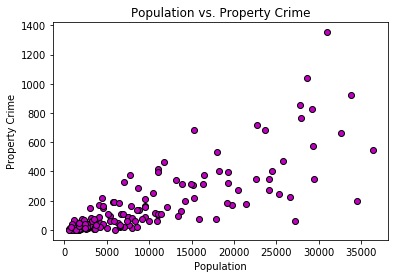

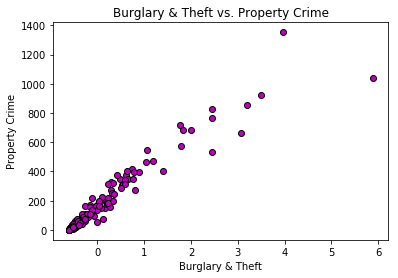

In [747]:
plt.scatter(y=crime['property_crime'], x=crime['population'],c='m',edgecolors='k')
plt.ylabel('Property Crime')
plt.xlabel('Population')
plt.title('Population vs. Property Crime')
plt.show()

plt.scatter(y=crime['property_crime'], x=crime['burglary_theft'],c='m',edgecolors='k')
plt.ylabel('Property Crime')
plt.xlabel('Burglary & Theft')
plt.title('Burglary & Theft vs. Property Crime')
plt.show()

**Features are linearly related to the target.** 

### Multivariate Normality

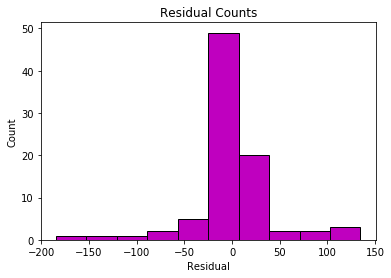

In [748]:
predicted = regr.predict(X_train).ravel()
actual = Y_train
residual = actual - predicted

plt.hist(residual,color='m',edgecolor='k')
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

**The residuals are approximately normally distributed.**

### Homoscedasticity

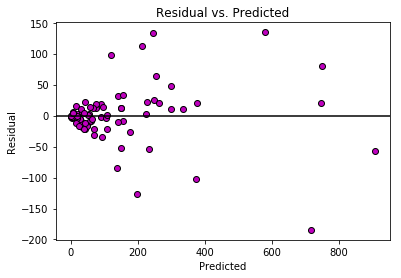

In [749]:
plt.scatter(predicted, residual,c='m',edgecolors='k')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0,c='k')
plt.title('Residual vs. Predicted')
plt.show()

**There is mild heteroscedasticity.**

### Low Multicollinearity

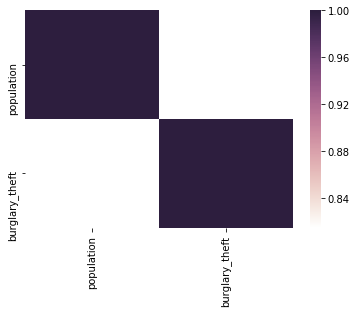

In [750]:
correlation_matrix = X_train.corr()
multicollinearity = sns.heatmap(correlation_matrix, cmap=sns.cubehelix_palette(light=1, as_cmap=True))
ticks = plt.xticks(rotation=90) 

**Multicollinearity has been minimized.**

## In-Sample Evaluation Against Test Split

In [751]:
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)
Y_pred = regr.predict(X_test)
print("Coefficient of Determination: {:.2f}%.".format(regr.score(X_test,Y_pred)*100))

Coefficient of Determination: 100.00%.


## Cross-Validation

In [752]:
regr = linear_model.LinearRegression()
scores = cross_val_score(regr, X_test, Y_test, cv=5, scoring = 'explained_variance')
print("Explained Variance Scores: {}.".format(scores))
print("Coefficient of Determination: {:.2f}% (+/- {:.2f}%).".format(scores.mean()*100, scores.std() * 200))

Explained Variance Scores: [0.89608522 0.84479295 0.77406367 0.93278986 0.88452477].
Coefficient of Determination: 86.65% (+/- 10.81%).


# KNN Regression Models: Weighted & Unweighted

## Feature Normalization

In [753]:
z_scaler = StandardScaler()
X = z_scaler.fit_transform(crime[['population','burglary_theft']])

## Fitting to Data & Scoring

### k = 15

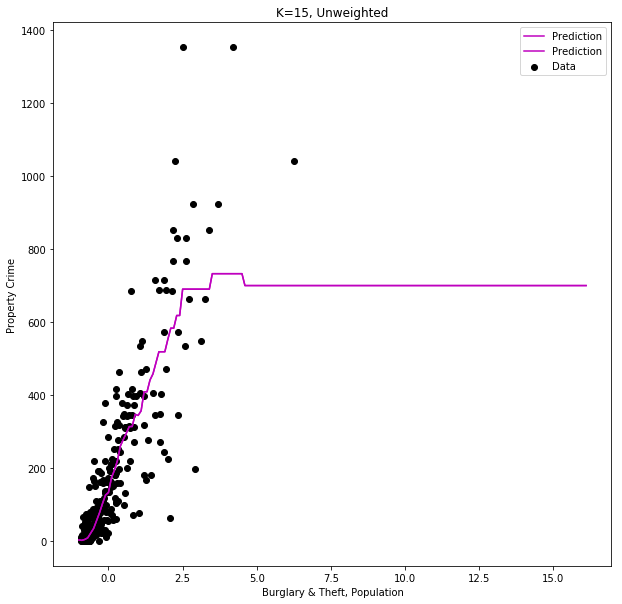

Unweighted Accuracy: 83.95% (+/- 13.82)%.


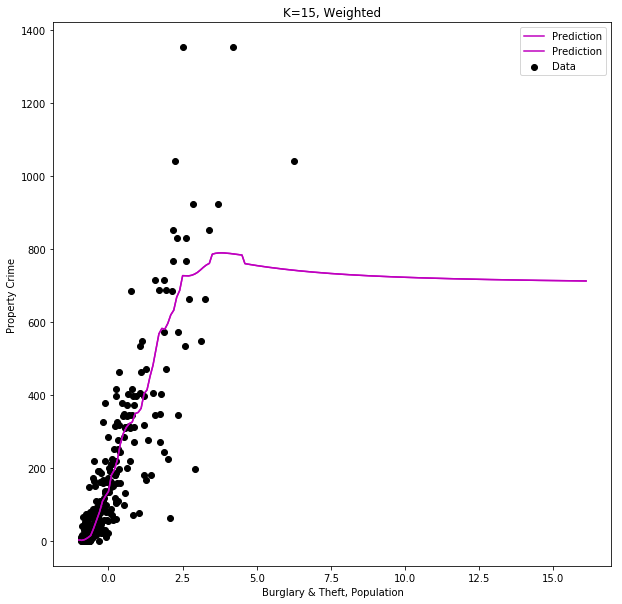

Weighted Accuracy: 88.33% (+/- 11.60)%.


In [754]:
#Unweighted KNN Regression.
knn = neighbors.KNeighborsRegressor(n_neighbors=15)
Y = np.column_stack([crime['property_crime'],crime['property_crime']])
X = X
knn.fit(X, Y)
T_x1 = np.arange(-1, 16.2, .1)[:, np.newaxis]
T_x2 = np.arange(-1, 16.2, .1)[:, np.newaxis]
T = np.column_stack([T_x1, T_x2])
Y_ = knn.predict(T)

plt.figure(figsize=(10,10))
plt.scatter(X, Y, color ='k', label='Data')
plt.plot(T, Y_, color ='m', label='Prediction')
plt.legend()
plt.ylabel('Property Crime')
plt.xlabel('Burglary & Theft, Population')
plt.title('K=15, Unweighted')
plt.show()

score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: {:.2f}% (+/- {:.2f})%.".format(score.mean()*100, score.std() * 200))


#Weighted KNN Regression.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=15, weights='distance')
knn_w.fit(X, Y)
Y_ = knn_w.predict(T)

plt.figure(figsize=(10,10))
plt.scatter(X, Y, color ='k', label='Data')
plt.plot(T, Y_, color ='m', label='Prediction')
plt.legend()
plt.ylabel('Property Crime')
plt.xlabel('Burglary & Theft, Population')
plt.title('K=15, Weighted')
plt.show()

score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: {:.2f}% (+/- {:.2f})%.".format(score_w.mean()*100, score_w.std() * 200))

### k = 10

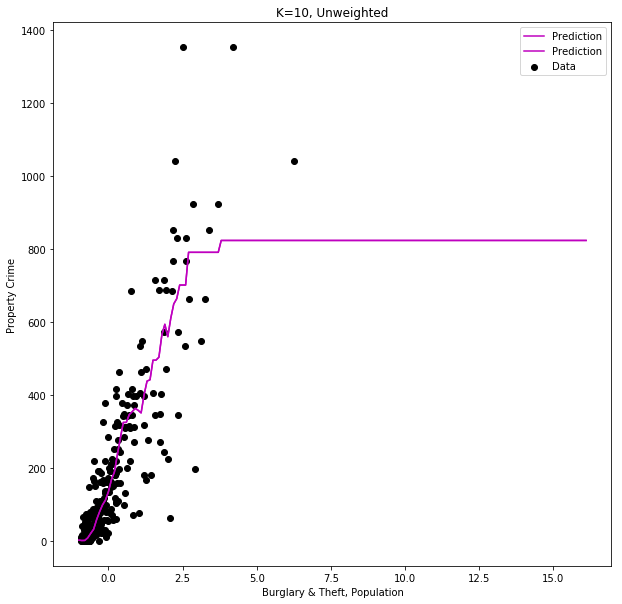

Unweighted Accuracy: 89.02% (+/- 11.29)%.


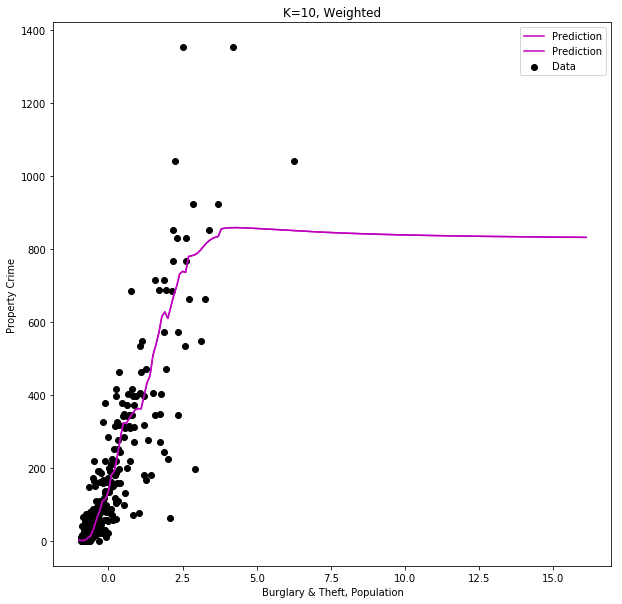

Weighted Accuracy: 90.50% (+/- 9.25)%.


In [755]:
#Unweighted KNN Regression.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
Y = np.column_stack([crime['property_crime'],crime['property_crime']])
X = X
knn.fit(X, Y)
T_x1 = np.arange(-1, 16.2, .1)[:, np.newaxis]
T_x2 = np.arange(-1, 16.2, .1)[:, np.newaxis]
T = np.column_stack([T_x1, T_x2])
Y_ = knn.predict(T)

plt.figure(figsize=(10,10))
plt.scatter(X, Y, color ='k', label='Data')
plt.plot(T, Y_, color ='m', label='Prediction')
plt.legend()
plt.ylabel('Property Crime')
plt.xlabel('Burglary & Theft, Population')
plt.title('K=10, Unweighted')
plt.show()

score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: {:.2f}% (+/- {:.2f})%.".format(score.mean()*100, score.std() * 200))


#Weighted KNN Regression.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
knn_w.fit(X, Y)
Y_ = knn_w.predict(T)

plt.figure(figsize=(10,10))
plt.scatter(X, Y, color ='k', label='Data')
plt.plot(T, Y_, color ='m', label='Prediction')
plt.legend()
plt.ylabel('Property Crime')
plt.xlabel('Burglary & Theft, Population')
plt.title('K=10, Weighted')
plt.show()

score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: {:.2f}% (+/- {:.2f})%.".format(score_w.mean()*100, score_w.std() * 200))

### k = 5

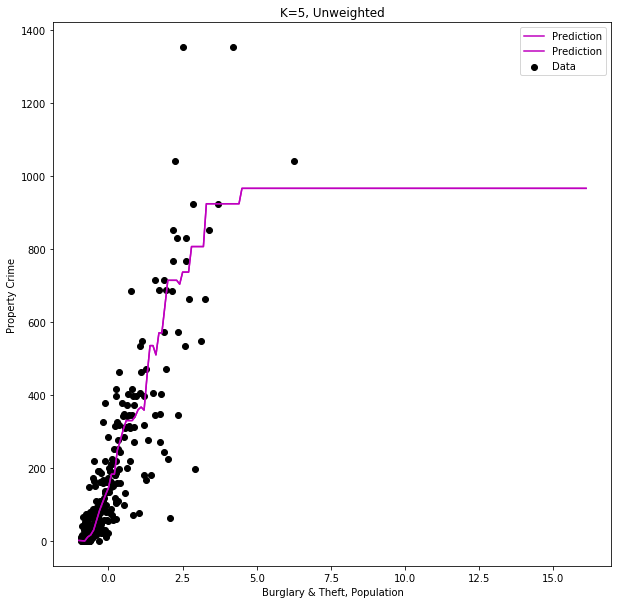

Unweighted Accuracy: 89.51% (+/- 5.90)%.


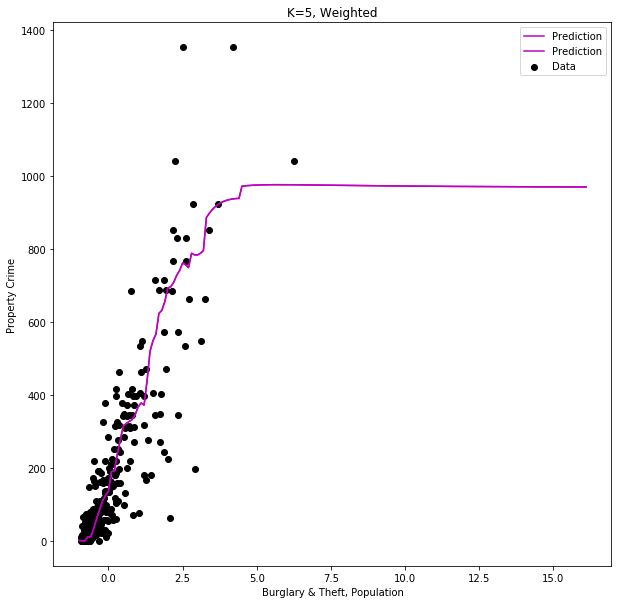

Weighted Accuracy: 89.89% (+/- 5.56)%.


In [756]:
#Unweighted KNN Regression.
knn = neighbors.KNeighborsRegressor(n_neighbors=5)
Y = np.column_stack([crime['property_crime'],crime['property_crime']])
X = X
knn.fit(X, Y)
T_x1 = np.arange(-1, 16.2, .1)[:, np.newaxis]
T_x2 = np.arange(-1, 16.2, .1)[:, np.newaxis]
T = np.column_stack([T_x1, T_x2])
Y_ = knn.predict(T)

plt.figure(figsize=(10,10))
plt.scatter(X, Y, color ='k', label='Data')
plt.plot(T, Y_, color ='m', label='Prediction')
plt.legend()
plt.ylabel('Property Crime')
plt.xlabel('Burglary & Theft, Population')
plt.title('K=5, Unweighted')
plt.show()

score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: {:.2f}% (+/- {:.2f})%.".format(score.mean()*100, score.std() * 200))


#Weighted KNN Regression.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
knn_w.fit(X, Y)
Y_ = knn_w.predict(T)

plt.figure(figsize=(10,10))
plt.scatter(X, Y, color ='k', label='Data')
plt.plot(T, Y_, color ='m', label='Prediction')
plt.legend()
plt.ylabel('Property Crime')
plt.xlabel('Burglary & Theft, Population')
plt.title('K=5, Weighted')
plt.show()

score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: {:.2f}% (+/- {:.2f})%.".format(score_w.mean()*100, score_w.std() * 200))

# Discussion

-  The weighted KNN Regression model is only marginally better than the Linear Regression model (88.33% +/- 11.60% vs. 86.65% +/- 10.81%) at k=15.
-  The weighted KNN Regression model meaningfully outperforms the Linear Regression Model at k=10 - accuracy peaks and error  decreases (90.50% +/- 9.25% vs. 86.65% +/- 10.81%). 
- At k=5, the weighted KNN Regression model's accuracy decreases, but so does its error.
-  Parameter tuning (feature standardization and weighting) are probably responsible for the weighted KNN Regression model outperforming  the Linear Regression model and the unweighted KNN Regression model (for all tested values of k). 
-   While it's possible to engineer features based on feedback about a Linear Regression model's assumptions, doing so while managing the tradeoff between performance improvement and overfitting isn't as straightforward as it seems to be for a weighted/unweighted KNN Regression Model.
